## Thêm thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


## Tiền xử lý

### read data

In [2]:
# Load the data
df = pd.read_csv('ABBV-AbbVie.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,79.769997,80.849998,79.279999,80.099998,62.999912,8567900
1,2019-03-04,80.400002,80.730003,79.110001,79.459999,62.496529,5872500
2,2019-03-05,79.379997,79.900002,78.720001,78.910004,62.063969,5933100
3,2019-03-06,79.129997,79.129997,77.559998,78.089996,61.419025,5293200
4,2019-03-07,77.769997,79.120003,77.440002,78.239998,61.537003,6642500
...,...,...,...,...,...,...,...
1254,2024-02-23,177.259995,178.910004,177.009995,178.089996,176.442200,3941800
1255,2024-02-26,178.839996,179.789993,178.000000,178.809998,177.155533,4327400
1256,2024-02-27,178.770004,179.529999,176.979996,178.990005,177.333878,3888500
1257,2024-02-28,179.850006,179.889999,176.889999,178.000000,176.353043,4331300


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df = df.set_index(pd.DatetimeIndex(df['Date'].values))

# Create new dataframe with Date and Close
df_close = pd.DataFrame(df, columns=['Close'])

### Data normalization

In [4]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1, 1))

### Data splitting

In [5]:
# Split the data into training and test sets
train_size = int(len(df_close) * 0.7)
test_size = len(df_close) - train_size

train_data = df_close[:train_size]
test_data = df_close[train_size:]

In [6]:
# Create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
	
time_step = 100

# Get lost data for test
train_last_windowsize = train_data[-time_step:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Model training and testing

In [7]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# Using early stopping to prevent overfitting
earlystop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=earlystop)

Epoch 1/100

13/13 [==============================] - 9s 187ms/step - loss: 0.1141
Epoch 2/100
13/13 [==============================] - 2s 174ms/step - loss: 0.0125
Epoch 3/100
13/13 [==============================] - 2s 185ms/step - loss: 0.0051
Epoch 4/100
13/13 [==============================] - 2s 153ms/step - loss: 0.0035
Epoch 5/100
13/13 [==============================] - 2s 132ms/step - loss: 0.0030
Epoch 6/100
13/13 [==============================] - 2s 156ms/step - loss: 0.0027
Epoch 7/100
13/13 [==============================] - 2s 164ms/step - loss: 0.0025
Epoch 8/100
13/13 [==============================] - 2s 166ms/step - loss: 0.0023
Epoch 9/100
13/13 [==============================] - 2s 119ms/step - loss: 0.0024
Epoch 10/100
13/13 [==============================] - 2s 139ms/step - loss: 0.0021
Epoch 11/100
13/13 [==============================] - 2s 165ms/step - loss: 0.0021
Epoch 12/100
13/13 [==============================] - 2s 152ms/step - loss: 0.0021
Epoch 13/100

### Testing process

In [9]:
# Predict
y_pred = model.predict(X_test)

12/12 [==============================] - 3s 28ms/step


### Evaluate model

In [10]:
# Evaluate the accuracy of the test set
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_test, y_pred)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSLE on Test dataset: {test_msle}")

MAPE on Test dataset: 0.027255007530119488
RMSE on Test dataset: 0.026800140439612985
MSLE on Test dataset: 0.00023450651585647775


## Predicting the next 30 days

### Preparing the prediction data

In [11]:
# Predict the next 30 days
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
prediction_next30_days = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        prediction_next30_days.extend(y_hat.tolist())
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())

# Print predictions for the next 30 days
print(prediction_next30_days)

[[0.9907101988792419], [0.9905363321304321], [0.9903463125228882], [0.9901293516159058], [0.9898906350135803], [0.9896384477615356], [0.9893819093704224], [0.9891300201416016], [0.9888906478881836], [0.9886696934700012], [0.9884722828865051], [0.9883017539978027], [0.9881593585014343], [0.988046407699585], [0.9879618287086487], [0.9879044890403748], [0.9878725409507751], [0.9878638982772827], [0.987875759601593], [0.9879049062728882], [0.9879487752914429], [0.9880049824714661], [0.9880706667900085], [0.9881430268287659], [0.988220751285553], [0.9883012175559998], [0.9883834719657898], [0.9884653091430664], [0.9885460734367371], [0.9886248707771301]]


### Preparing the forecast date index

In [12]:
# Print predictions for the next 30 days
print(prediction_next30_days)

# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')

# Convert predictions back to original scale
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)
y_pred = scaler.inverse_transform(y_pred)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

[[0.9907101988792419], [0.9905363321304321], [0.9903463125228882], [0.9901293516159058], [0.9898906350135803], [0.9896384477615356], [0.9893819093704224], [0.9891300201416016], [0.9888906478881836], [0.9886696934700012], [0.9884722828865051], [0.9883017539978027], [0.9881593585014343], [0.988046407699585], [0.9879618287086487], [0.9879044890403748], [0.9878725409507751], [0.9878638982772827], [0.987875759601593], [0.9879049062728882], [0.9879487752914429], [0.9880049824714661], [0.9880706667900085], [0.9881430268287659], [0.988220751285553], [0.9883012175559998], [0.9883834719657898], [0.9884653091430664], [0.9885460734367371], [0.9886248707771301]]


## Visualization

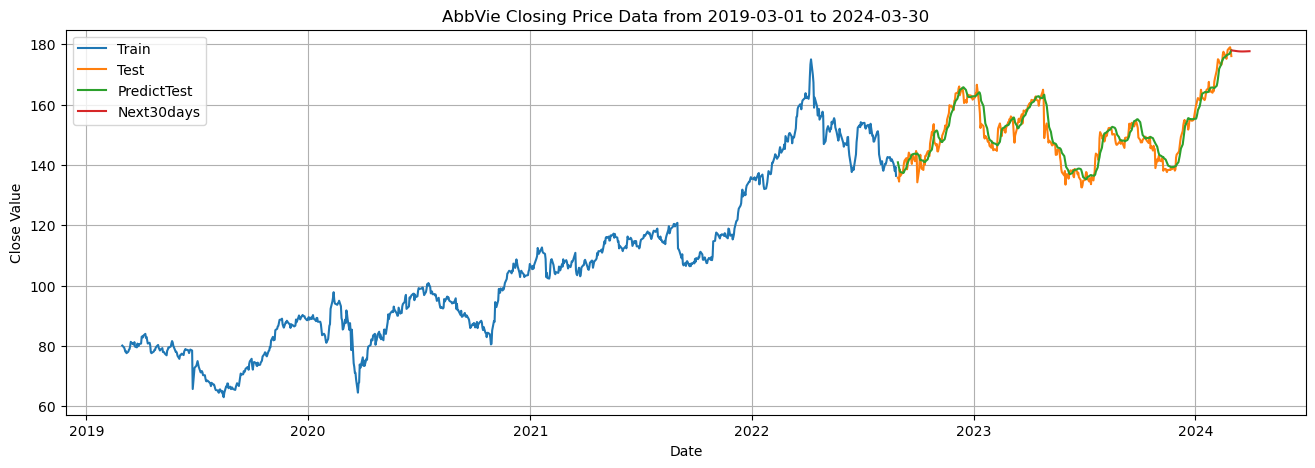

In [13]:
# Plotting
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], train_data, label='Train')
plt.plot(df.index[train_size:], test_data, label='Test')
plt.plot(df.index[train_size:], y_pred, label='PredictTest')
plt.plot(future_dates, prediction_next30_days, label='Next30days')

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title(f"AbbVie Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")
plt.legend()
plt.grid()
plt.savefig('Image/LSTM_73_30days_ABBV.png')
plt.show()